In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
mpl.rcParams['axes.titleweight']='bold'

In [3]:
df = pd.read_excel(r'C:\Users\Nishankur\Documents\Placement projects\DS-assignment\Part1.xlsx')
df.head()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,1,575,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,2,1240,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,3,1060,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,2,875,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,1,491,43.1


In [4]:
#Renaming some features
df = df.rename(columns={'Distance from nearest Metro station (km)':'MetroDist',
                  'Number of convenience stores':'Stores_count',
                  'Number of bedrooms':'Bedrooms',
                   'House size (sqft)':'Size(sqft)',
                   'House price of unit area':'PricePerArea'
                  })
df_reg = df.copy()

# Exploratory Data Analysis

In [5]:
df.describe()

,Transaction date,House Age,MetroDist,Stores_count,latitude,longitude,Bedrooms,Size(sqft),PricePerArea
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,1.987923,931.475845,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,0.818875,348.910269,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,1.000000,402.000000,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,1.000000,548.000000,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,2.000000,975.000000,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,3.000000,1234.750000,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,3.000000,1500.000000,117.500000


In [6]:
#Categorising the price
df_desc = df.describe()
df_25 = df_desc.loc['25%','PricePerArea']
df_50 = df_desc.loc['50%','PricePerArea']
df_75 = df_desc.loc['75%','PricePerArea']

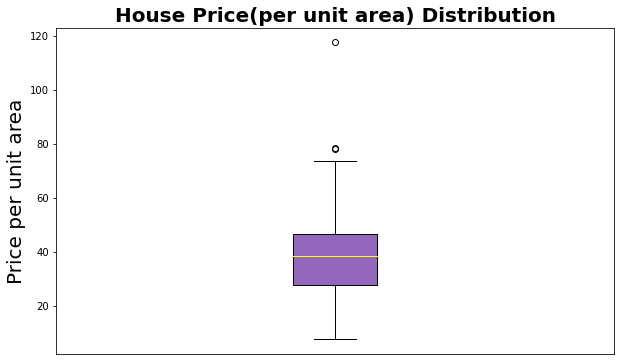

In [7]:
# Price distribution
plt.figure(figsize=(10,6))
plt.title('House Price(per unit area) Distribution',fontdict={'fontsize':20})
plt.ylabel('Price per unit area',fontdict={'fontsize':20})
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,     
    top=False,        
    labelbottom=False) 
box = plt.boxplot(df['PricePerArea'],patch_artist=True)
box['boxes'][0].set_facecolor('#9467bd')
box['medians'][0].set_color( 'yellow')
plt.show()

**It is clear from the figure that the data is right skewed with outliers towards the higher price(per unit area) range.**

In [8]:
#Checking for any null values
df.isnull().sum()

Transaction date    0
House Age           0
MetroDist           0
Stores_count        0
latitude            0
longitude           0
Bedrooms            0
Size(sqft)          0
PricePerArea        0
dtype: int64

In [9]:
#Checking the data type of features
df.dtypes

Transaction date    float64
House Age           float64
MetroDist           float64
Stores_count          int64
latitude            float64
longitude           float64
Bedrooms              int64
Size(sqft)            int64
PricePerArea        float64
dtype: object

In [10]:
#Dividing the features into categorical and numerical features
numerical = ['Transaction date','House Age','MetroDist','latitude','longitude','Size(sqft)','PricePerArea']
categorical = ['Stores_count','Bedrooms']

#Checking the correlation of target price with the numerical features
df[numerical].corr()['PricePerArea']

Transaction date    0.087529
House Age          -0.210567
MetroDist          -0.673613
latitude            0.546307
longitude           0.523287
Size(sqft)          0.046489
PricePerArea        1.000000
Name: PricePerArea, dtype: float64

**The parameters that significantly affect the house price are:**
1. House Age : The price(per unit area) seems to decrease with the increase in age, which is fairly obvious. But, the effect is not extremely strong.
2. Distance from nearest Metro station (km) : As the distance from the nearest metro increases the price(per unit area) of the house decreases.
3. Location : The location(longitude and latitude) shows a positive correlation with the price(per unit area). 
4. Transaction date and Size(sqft): Both these parameters show negligible affect on the price(per unit area).


In [11]:
#Calculating the number of houses vs. number of convenience stores
df['Stores_count'].value_counts()

5     67
0     67
3     46
1     46
6     37
7     31
4     31
8     30
9     25
2     24
10    10
Name: Stores_count, dtype: int64

In [12]:
#Collecting the number of houses per convenience store count
store_box = []

for i in sorted(df['Stores_count'].unique()):
    val = df[df['Stores_count']==i]['PricePerArea'].values
    store_box.append(val)

In [13]:
df['Bedrooms'].value_counts()

1    141
2    137
3    136
Name: Bedrooms, dtype: int64

In [14]:
#Collecting the number of houses per bedroom count
bedroom_box = []

for i in sorted(df['Bedrooms'].unique()):
    val = df[df['Bedrooms']==i]['PricePerArea'].values
    bedroom_box.append(val)


In [15]:
#Creation of price range column
def price_cat(x):
    if x<=df_25:
        return 'low'
    elif x>df_25 and x<=df_50:
        return 'medium'
    elif x>df_50 and x<=df_75:
        return 'high'
    elif x>df_75:
        return 'luxury'
        

df['Price_cat'] = df['PricePerArea'].apply(price_cat)   

**The house price(per unit area) categories have been marked as follows:**
  
  Below **27.7** per sq. unit (including the upper limit): **low**
  
  Between **27.7** and **38.45** per sq. unit (including the upper limit): **medium**
  
  Between **38.45** and **46.6** per sq. unit (including the upper limit): **high**
  
  Above **46.6** per sq. unit: **luxury**
  
  **Note:** Total prices of the houses have not been used for the category splitting because the objective is to predict the price(per unit area). 

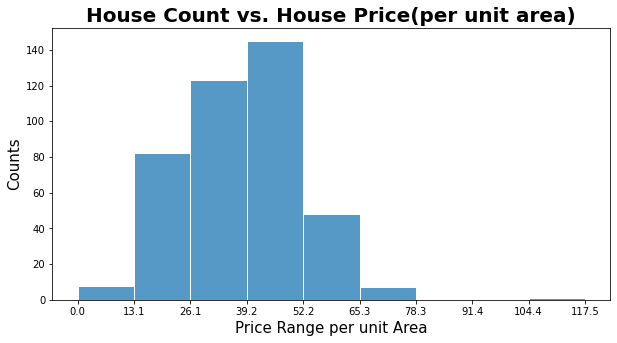

In [16]:
price_range = np.linspace(0,df['PricePerArea'].max(),10)
fig,ax = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(10)
# House Count vs House Price
price_range = np.linspace(0,df['PricePerArea'].max(),10)
ax.set_title('House Count vs. House Price(per unit area)',fontdict={'fontsize':20})
ax.set_xticks(price_range)
ax.set_xlabel('Price Range per unit Area',fontdict={'fontsize':15})
ax.set_ylabel('Counts',fontdict={'fontsize':15})
sns.histplot(df['PricePerArea'],bins=price_range,edgecolor='white', linewidth=1)
plt.show()

**As can be seen, the plot of House Count vs. House Price is right skewed indicating that most of the houses fall in the middle price category. Majority of the houses are in the price range of 39.2-52.2 per unit area** 

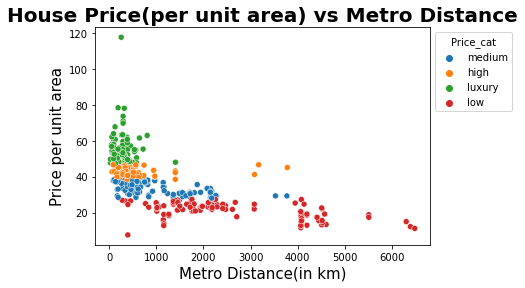

In [17]:
#Checking price variation w.r.t Metro Distance(sqft)
plt.title('House Price(per unit area) vs Metro Distance',fontdict={'fontsize':20})
plt.ylabel('Price per unit area',fontdict={'fontsize':15})
plt.xlabel('Metro Distance(in km)',fontdict={'fontsize':15})
s = sns.scatterplot(x = df['MetroDist'],y = df['PricePerArea'],hue=df['Price_cat'])
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.show()

**1. Most of the high price(per unit area) houses are located very close to the metro station.**

**2. Some of the medium range and low range houses are also located near the metro station.**

**3. But as the distance from the metro station increases clearly the prices(per unit area) fall.**

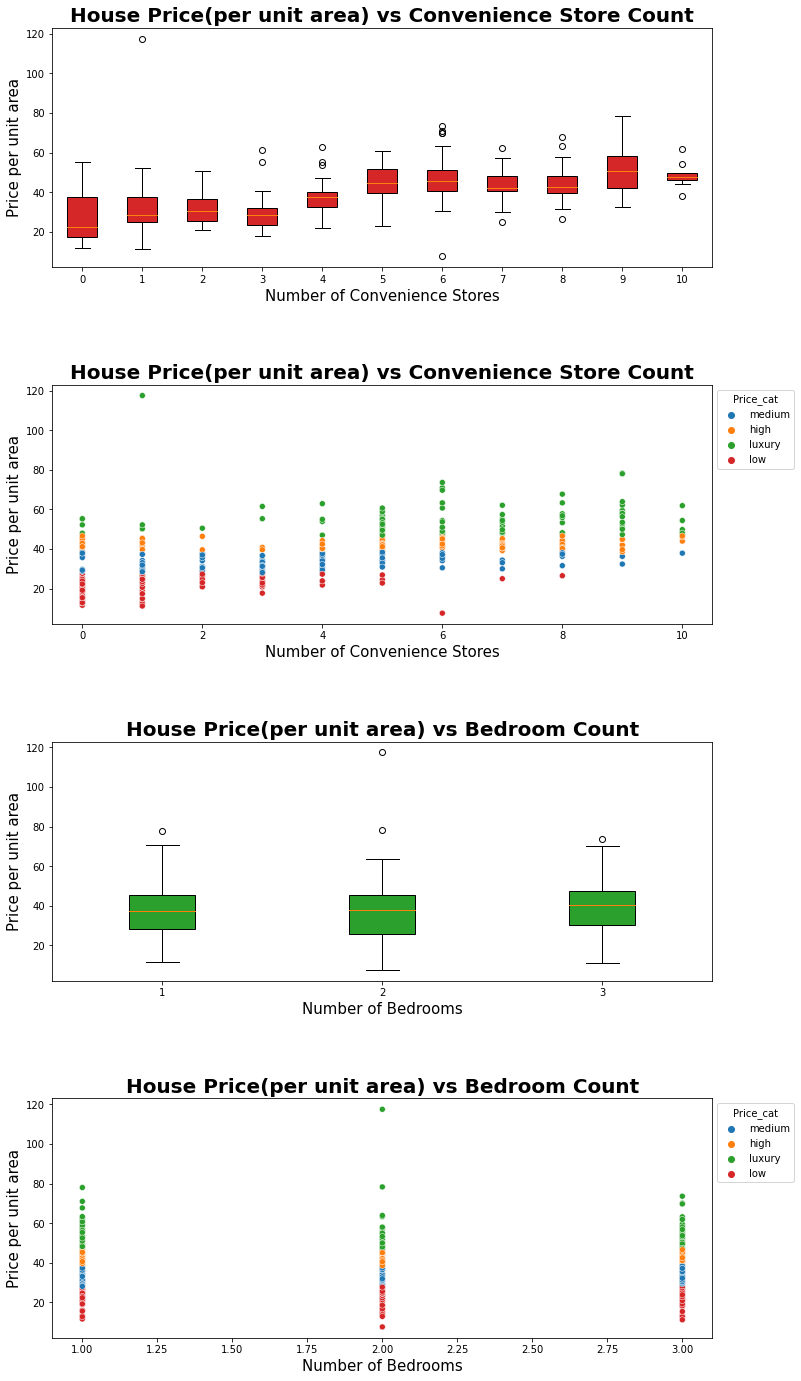

In [18]:
fig,ax = plt.subplots(4,1)
fig.tight_layout(pad=0.25)
fig.set_figheight(20)
fig.set_figwidth(10)
# House Price vs Convenience Store Count(Boxplot)
ax[0].set_title('House Price(per unit area) vs Convenience Store Count',fontdict={'fontsize':20})
ax[0].set_xlabel('Number of Convenience Stores',fontdict={'fontsize':15})
ax[0].set_ylabel('Price per unit area',fontdict={'fontsize':15})
ax[0].boxplot(store_box,positions = sorted(df['Stores_count'].unique()),patch_artist=True,boxprops=dict(facecolor='#d62728'))

# House Price vs Convenience Store Count(Scatterplot)
ax[1].set_title('House Price(per unit area) vs Convenience Store Count',fontdict={'fontsize':20})
ax[1].set_xlabel('Number of Convenience Stores',fontdict={'fontsize':15})
ax[1].set_ylabel('Price per unit area',fontdict={'fontsize':15})
leg2 = sns.scatterplot(x=df['Stores_count'],y=df['PricePerArea'],hue=df['Price_cat'],ax=ax[1])
sns.move_legend(leg2, "upper left", bbox_to_anchor=(1, 1))

#House Price vs Bedroom count
ax[2].set_title('House Price(per unit area) vs Bedroom Count',fontdict={'fontsize':20})
ax[2].set_xlabel('Number of Bedrooms',fontdict={'fontsize':15})
ax[2].set_ylabel('Price per unit area',fontdict={'fontsize':15})
ax[2].boxplot(bedroom_box,positions = sorted(df['Bedrooms'].unique()),patch_artist=True,boxprops=dict(facecolor='#2ca02c'))

#House Price vs Bedroom count(Scatterplot)
ax[3].set_title('House Price(per unit area) vs Bedroom Count',fontdict={'fontsize':20})
ax[3].set_xlabel('Number of Bedrooms',fontdict={'fontsize':15})
ax[3].set_ylabel('Price per unit area',fontdict={'fontsize':15})
leg4 = sns.scatterplot(x=df['Bedrooms'],y=df['PricePerArea'],hue=df['Price_cat'],ax=ax[3])
sns.move_legend(leg4, "upper left", bbox_to_anchor=(1, 1))
plt.show()

**Comparison of House Price(per unit area) w.r.t Convenience Store count**
1. The houses in the locations without any convenience stores, show a wide spread in the price range.
2. The house prices(per unit area) in the locations with 10 convenience stores don't show much variation.
3. The number of luxury houses seems to increase with the increase in number of nearby convenience stores.
4. It is note worthy that there are very few or no low price(per unit area) range houses in the regions with greater number of convenience stores.  

**Comparison of House Price(per unit area) w.r.t Bedroom count**
1. House prices(per unit area) seem to show a balanced spread across the bedroom counts, which is counter intuitive.
2. One noteworthy observation is that, few houses with extremely high price(per unit area) lie in the 2 bedroom category.
3. Another noteworthy observation is that, spread in house price(per unit area) across number of bedrooms category, looks similar.

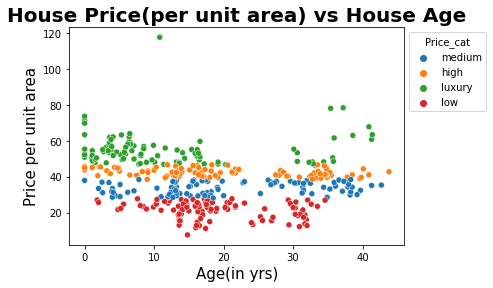

In [19]:
#Checking price variation w.r.t age
plt.title('House Price(per unit area) vs House Age',fontdict={'fontsize':20})
plt.ylabel('Price per unit area',fontdict={'fontsize':15})
plt.xlabel('Age(in yrs)',fontdict={'fontsize':15})
sp = sns.scatterplot(data = df,x = 'House Age',y = 'PricePerArea',hue='Price_cat')
sns.move_legend(sp, "upper left", bbox_to_anchor=(1, 1))
plt.show()

**Comparison of House Price(per unit area) w.r.t Age**
1. House prices(per unit area) seem to fall slightly with increase in age, with a few exceptions in the luxury category.

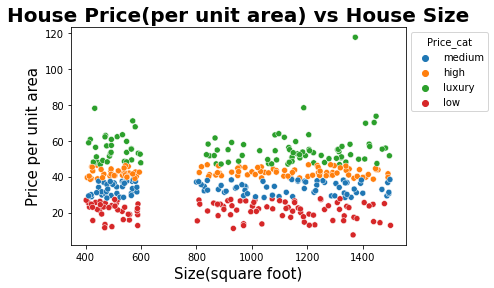

In [20]:
#Checking price variation w.r.t Size(sqft)
plt.title('House Price(per unit area) vs House Size',fontdict={'fontsize':20})
plt.ylabel('Price per unit area',fontdict={'fontsize':15})
plt.xlabel('Size(square foot)',fontdict={'fontsize':15})
splt = sns.scatterplot(x = df['Size(sqft)'],y = df['PricePerArea'],hue=df['Price_cat'])
sns.move_legend(splt, "upper left", bbox_to_anchor=(1, 1))
plt.show()

**Comparison of House Price(per unit area) w.r.t Bedroom count**
1. Size shows negligible affect on the price(per unit area) as a whole, which is counter intuitive.
2. A few exceptions are seen in the luxury category where the price increases with size.
3. In the low category, prices(per unit area) show a slightly downward trend.
4. Another note worthy observation is that, no houses are there in the 600-800(sq.ft.) size range.

# Feature Engineering

**Since we have the coordinates of the houses, clustering them into groups of similar locations will give us a good idea about the affect of locations on the house prices(per unit area). If this shows a trend, this classification data can be used in the price(per unit area) prediction of the houses.**

In [21]:
#Collecting the location coordinates
locations = df[['latitude', 'longitude']].values

In [22]:
#Forming clusters using DBSCAN
dbscn = DBSCAN(eps=0.74/6371.0088, min_samples=1, algorithm='ball_tree', metric='haversine')
dbscn.fit(np.radians(locations))
df['Sim_loc'] = [str(x) for x in dbscn.labels_]

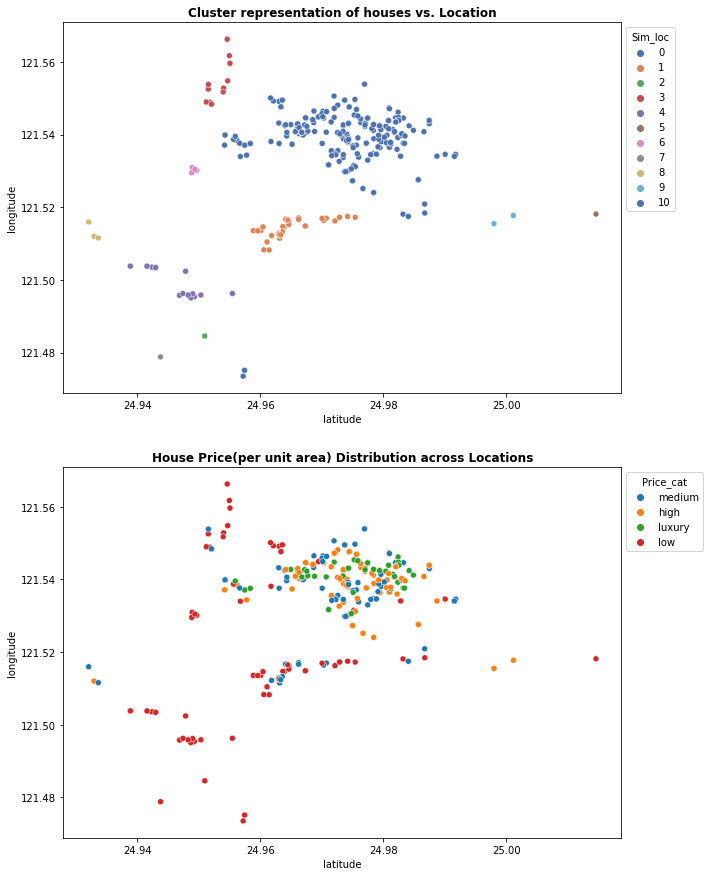

In [23]:
#Visual representation of 
fig,ax = plt.subplots(2,1)
fig.set_figheight(15)
fig.set_figwidth(10)
#Plotting the location clusters
loc_grp = sns.scatterplot(x= df['latitude'],y= df['longitude'],hue = df['Sim_loc'],palette='deep',ax=ax[0])
ax[0].set_title('Cluster representation of houses vs. Location')
sns.move_legend(loc_grp, "upper left", bbox_to_anchor=(1, 1))

#Plotting the House Price(per unit area) Distribution across Locations
price_grp = sns.scatterplot(x= df['latitude'],y= df['longitude'],hue = df['Price_cat'],ax=ax[1])
ax[1].set_title('House Price(per unit area) Distribution across Locations')
sns.move_legend(price_grp, "upper left", bbox_to_anchor=(1, 1))

plt.show()

**1.It can be seen that the houses can be divided into clear clusters based on location.**

**2. Also, it is evident that, most houses in some regions belong to low category and in some others to high or luxury category.**

**Thus, location clusters can be used for the predictions.**

**Note:** This feature engineering is just for EDA purposes. The feature engineering for the prediction will be done after splitting the data into training and testing sets, so that there is no information leakage.

# Model Development

In [24]:
#importing the necessary libraries
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [25]:
df_reg.drop(columns=['Transaction date'],inplace=True)

In [26]:
#Generating uniformly distributed random numbers
df_reg['random'] = np.random.rand(len(df_reg))

In [27]:
#Splitting the data into training and testing sets
df_train = df_reg[df_reg['random']<=0.9]
df_test = df_reg[df_reg['random']>0.9]

In [28]:
df_train.shape

(361, 9)

In [29]:
df_test.shape 

(53, 9)

In [30]:
df_train.drop(columns=['random'],inplace=True)
df_test.drop(columns=['random'],inplace=True)

In [31]:
#Collecting the values to be predicted
y_train = df_train['PricePerArea'].to_numpy()
y_test = df_test['PricePerArea'].to_numpy()

In [32]:
#Dropping the Price column from the feature set
df_train.drop(columns=['PricePerArea'],inplace=True)
df_test.drop(columns=['PricePerArea'],inplace=True)

**Feature Engineering and Preprocessing**

In [33]:
#Collecting the location coordinates
locations_reg = df_train[['latitude', 'longitude']].values

In [34]:
#Forming clusters using DBSCAN
dbscn_reg = DBSCAN(eps=0.74/6371.0088, min_samples=1, algorithm='ball_tree', metric='haversine')
dbscn_reg.fit(np.radians(locations_reg))
df_train['Sim_loc'] = dbscn_reg.labels_
df_new_data = df_train.copy()


**Since DBSCAN doesn't have any prediction capabilities we will train a classifier to predict the cluster to a new point belongs using KNN classifier.**

**Note:** This is based on the assumption that the price estimations are for a particular region.

In [35]:
#Fitting KNN model to assign location clusters to new data   
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score

locKNN = KNeighborsRegressor(weights='distance', metric='haversine')

X_KNN, y_KNN = (np.radians(locations_reg),df_train['Sim_loc'].values)

locKNN.fit(X_KNN,y_KNN)

y_pred_KNN = locKNN.predict(X_KNN)
y_pred_KNN = y_pred_KNN.astype('int64')

accuracy_score(y_KNN,y_pred_KNN)

1.0

In [36]:
#One hot encoding of the categorical variables
df_train = pd.get_dummies(df_train,prefix=['Stores','Bedrooms','Sim_loc'],columns=['Stores_count','Bedrooms','Sim_loc'])

In [37]:
#Dropping coordinates as they don't have any direct use
df_train.drop(columns=['latitude','longitude'],inplace=True)

In [38]:
X_train = df_train.to_numpy()

In [39]:
std = StandardScaler()
X_train = std.fit_transform(X_train)

**Preprocessing of new data**

In [40]:
#Function to preprocess test data
def new_data_pp(dataset, scale = std):
    location = dataset[['latitude', 'longitude']].values
    X_KNN = np.radians(location)
    dataset['Sim_loc'] = locKNN.predict(X_KNN).astype('int64')
    i = dataset.index 
    temp_df = pd.concat([df_new_data,dataset])
    #One hot encoding of the categorical variables
    temp_df = pd.get_dummies(temp_df,prefix=['Stores','Bedrooms','Sim_loc'],columns=['Stores_count','Bedrooms','Sim_loc'])
    
    dataset = temp_df.iloc[i]
    #Dropping coordinates as they don't have any direct use
    dataset.drop(columns=['latitude','longitude'],inplace=True)
    
    X_new = dataset.to_numpy()
    X_new = scale.transform(X_new)
    
    return X_new

# Model Building

## Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline

**Multiple Regression**

In [42]:
lr = LinearRegression()

In [43]:
#Fitting the model
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
#Checking model acccuracy
lr.score(X_train, y_train)

0.6248602245428713

**Polynomial Regression**

In [45]:
X_poly = X_train

In [46]:
#Fitting Polynomial Regression model(deg = 2)
Input2=[('polynomial', PolynomialFeatures(degree=2,include_bias=False)),('model',LinearRegression())]
pipeline2 = Pipeline(Input2)
pipeline2.fit(X_poly,y_train)
#Checking model acccuracy
pipeline2.score(X_poly,y_train)

0.761425645693275

In [47]:
#Fitting Polynomial Regression model(deg = 3)
Input3=[('polynomial', PolynomialFeatures(degree=3,include_bias=False)),('model',LinearRegression())]
pipeline3 = Pipeline(Input3)
pipeline3.fit(X_poly,y_train)
#Checking model acccuracy
pipeline3.score(X_poly,y_train)

0.9634943152693424

**Ridge Regression**

In [48]:
poly = PolynomialFeatures(degree=2)
X_poly2 = poly.fit_transform(X_poly)

In [49]:
# List of hyper-parameters to tune for original training data
params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,5,10, 20, 50, 100, 500, 1000],'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

# List of alpha to tune the hyper-parameters for Polynomial transformed data (degree=3)
params_poly = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,5,10, 20, 50, 100, 500, 1000]}

#Fitting the model
rdgReg = Ridge()


In [50]:
cv_ridge = GridSearchCV(estimator=rdgReg, param_grid=params,scoring='r2',n_jobs=-1)
cv_ridge_poly = GridSearchCV(estimator=rdgReg, param_grid=params_poly,scoring='r2',n_jobs=-1)

In [51]:
#Fitting the original training data
cv_ridge.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 2.0, 5, 10, 20, 50, 100, 500, 1000],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             scoring='r2')

In [52]:
print("The best estimator: ",cv_ridge.best_estimator_)
print("\nThe best score:",cv_ridge.best_score_)
print("\nThe best parameters:",cv_ridge.best_params_)

The best estimator:  Ridge(alpha=10)

The best score: 0.5943223095556928

The best parameters: {'alpha': 10, 'solver': 'auto'}


Degree 2 polynomial transformed features

In [53]:
#Fitting the transformed training data, PolynomialFeatures(degree=2)
X_ridge_poly = poly.fit_transform(X_poly)
cv_ridge_poly.fit(X_poly2,y_train)

GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 2.0, 5, 10, 20, 50, 100, 500, 1000]},
             scoring='r2')

In [54]:
print("The best estimator: ",cv_ridge_poly.best_estimator_)
print("\nThe best score:",cv_ridge_poly.best_score_)
print("\nThe best parameters:",cv_ridge_poly.best_params_)

The best estimator:  Ridge(alpha=500)

The best score: 0.552830382426162

The best parameters: {'alpha': 500}


**Lasso Regression**

In [55]:
params_lasso = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5,1.0, 2.0,5,10, 20, 50, 100, 500, 1000]}

In [56]:
lasso_reg = Lasso()

cv_lasso = GridSearchCV(estimator=lasso_reg,param_grid=params_lasso,scoring='r2',verbose=1)

#Fitting the model
cv_lasso.fit(X_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5, 10, 20,
                                   50, 100, 500, 1000]},
             scoring='r2', verbose=1)

In [57]:
#Checking model acccuracy
print("The best estimator: ",cv_lasso.best_estimator_)
print("\nThe best score:",cv_lasso.best_score_)
print("\nThe best parameters:",cv_lasso.best_params_)

The best estimator:  Lasso(alpha=0.1)

The best score: 0.5963069324531289

The best parameters: {'alpha': 0.1}


Degree 2 polynomial transformed features

In [58]:
cv_lasso_poly = GridSearchCV(estimator=lasso_reg,param_grid=params_lasso,scoring='r2',verbose=1)

#Fitting the model
cv_lasso_poly.fit(X_poly2,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5, 10, 20,
                                   50, 100, 500, 1000]},
             scoring='r2', verbose=1)

In [59]:
#Checking model acccuracy
print("The best estimator: ",cv_lasso_poly.best_estimator_)
print("\nThe best score:",cv_lasso_poly.best_score_)
print("\nThe best parameters:",cv_lasso_poly.best_params_)

The best estimator:  Lasso(alpha=0.4)

The best score: 0.6195821946604874

The best parameters: {'alpha': 0.4}


## Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

In [61]:
gbReg = GradientBoostingRegressor()

In [62]:
params = {'learning_rate': [0.01,0.02,0.025,0.03,0.04,],'max_features':[5,10,15,20,25],'n_estimators' : [50,100,500,],'max_depth': [2,4,6,8,10,12]}

In [63]:
#Fitting the model
cv_gbReg = GridSearchCV(estimator=gbReg, param_grid = params, n_jobs=-1,scoring='r2')
cv_gbReg.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.025, 0.03, 0.04],
                         'max_depth': [2, 4, 6, 8, 10, 12],
                         'max_features': [5, 10, 15, 20, 25],
                         'n_estimators': [50, 100, 500]},
             scoring='r2')

In [64]:
#Checking model acccuracy
print("The best estimator: ",cv_gbReg.best_estimator_)
print("\nThe best score:",cv_gbReg.best_score_)
print("\nThe best parameters:",cv_gbReg.best_params_)

The best estimator:  GradientBoostingRegressor(learning_rate=0.03, max_depth=6, max_features=10)

The best score: 0.686702761540607

The best parameters: {'learning_rate': 0.03, 'max_depth': 6, 'max_features': 10, 'n_estimators': 100}


Degree 2 polynomial transformed features

In [65]:
#Fitting the model
cv_gbReg_poly = GridSearchCV(estimator=gbReg, param_grid = params, n_jobs=-1,scoring='r2')
cv_gbReg_poly.fit(X_poly2, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.025, 0.03, 0.04],
                         'max_depth': [2, 4, 6, 8, 10, 12],
                         'max_features': [5, 10, 15, 20, 25],
                         'n_estimators': [50, 100, 500]},
             scoring='r2')

In [66]:
#Checking model acccuracy
print("The best estimator: ",cv_gbReg_poly.best_estimator_)
print("\nThe best score:",cv_gbReg_poly.best_score_)
print("\nThe best parameters:",cv_gbReg_poly.best_params_)

The best estimator:  GradientBoostingRegressor(learning_rate=0.04, max_depth=4, max_features=10)

The best score: 0.6962835506860168

The best parameters: {'learning_rate': 0.04, 'max_depth': 4, 'max_features': 10, 'n_estimators': 100}


# Model Evaluation

In [67]:
from math import sqrt

In [68]:
#Pre processing test features
X_eval = new_data_pp(df_test, scale = std)

**Multiple Regression**

In [69]:
y_lr = lr.predict(X_eval)
error_lr = mse(y_test,y_lr)

In [70]:
print('Root mean squared error for multiple regression is:',sqrt(error_lr))

Root mean squared error for multiple regression is: 16.031286562268694


**Polynomial Regression**

In [71]:
#Degree 2
y_p2 = pipeline2.predict(X_eval)
error_p2 = mse(y_test,y_p2)

In [93]:
print('Root mean squared error for polynomial regression(degree=2) is:',sqrt(error_p2))

Root mean squared error for polynomial regression(degree=2) is: 17.74656309647053


In [73]:
#Degree 3
y_p3 = pipeline3.predict(X_eval)
error_p3 = mse(y_test,y_p3)

In [91]:
print('Root mean squared error for polynomial regression(degree=3) is:',sqrt(error_p3))

Root mean squared error for polynomial regression(degree=3) is: 386828.08584675496


**Ridge regression**

Original test data

In [75]:
y_ridge = cv_ridge.predict(X_eval)
error_ridge = mse(y_test,y_ridge)

In [76]:
print('Root mean squared error for Ridge regression with original data is:',sqrt(error_ridge))

Root mean squared error for Ridge regression with original data is: 15.947848321692657


Degree 2 Polynomial transformed data

In [77]:
poly_eval = PolynomialFeatures(degree=2)
X_eval2 = poly_eval.fit_transform(X_eval)

In [78]:
y_ridge2 = cv_ridge_poly.predict(X_eval2)
error_ridge2 = mse(y_test,y_ridge2)

In [95]:
print('Root mean squared error for Ridge regression with degree 2 Polynomial transformed data is:',sqrt(error_ridge2))

Root mean squared error for Ridge regression with degree 2 Polynomial transformed data is: 15.868864235966432


**Lasso Regression**


Original test data

In [80]:
y_lasso = cv_lasso.predict(X_eval)
error_lasso = mse(y_test,y_lasso)

In [81]:
print('Root mean squared error for Ridge regression with original data is:',sqrt(error_lasso))

Root mean squared error for Ridge regression with original data is: 15.830886437945113


Degree 2 Polynomial transformed data

In [82]:
y_lasso2 = cv_ridge_poly.predict(X_eval2)
error_lasso2 = mse(y_test,y_lasso2)

In [94]:
print('Root mean squared error for Lasso regression with degree 2 Polynomial transformed data is:',sqrt(error_lasso2))

Root mean squared error for Lasso regression with degree 2 Polynomial transformed data is: 15.868864235966432


**Gradient Boosting**

Original test data

In [84]:
y_gb = cv_gbReg.predict(X_eval)
error_gb = mse(y_test,y_gb)

In [85]:
print('Root mean squared error for Gradient Boosting with original data is:',sqrt(error_gb))

Root mean squared error for Gradient Boosting with original data is: 16.807752725755503


Degree 2 Polynomial transformed data

In [86]:
y_gb2 = cv_gbReg_poly.predict(X_eval2)
error_gb2 = mse(y_test,y_gb2)

In [89]:
print('Root mean squared error for Gradient Boosting with degree 2 Polynomial transformed data is:',sqrt(error_gb2))

Root mean squared error for Gradient Boosting with degree 2 Polynomial transformed data is: 16.877546313509033


# Assumptions and Drawbacks

## Linear Regression


Multiple Regression: It assumes that the data has a linear realtionship with the features and based on that tries to predict the price by fitting the weights to yield the best results.

Ridge Regression:  It makes the same assumptions as Multiple Regression and based on that tries to predict the price by fitting the weights to yield the best results. Here, l2 regularization prevent overfitting or underfitting.


Lasso Regression: It makes the same assumptions as Multiple Regression and based on that tries to predict the price by fitting the weights to yield the best results. Here, l1 regularization prevent overfitting or underfitting.



**Drawbacks:** All these methods assume that the features have a strong correlation with the target variable and if it doesn't exist, these algorithms fail to capture any important characteristics and result in very bad predictions.

## Polynomial regression

It assumes that the features have some kind of polynomial(degree>1) relationship with the target variable and attempts to build on that by fitting the best possible curve and predict the target variable.


**Drawbacks:** This method is extremely prone to overfitting at large n(i.e. degree of the polynomial)

## Gradient Boosting

It is an ensemble based model and involves training each predictor on the residual errors of the preceding predictor.

**Drawbacks:** This method is extremely time consuming when there are large number of features. It is also prone to overfitting.

# Result

1. The features and target seem to have a polynomial relationship and hence the best results have been achieved by transforming the features into a degree 2 polynomial.



2. Following the transformation, either L1 or L2 regularization applied during the training via lasso and ridge regression, respectively, have produced the best results with minimum root mean square errors of 15.868, each.


3. Gradient Boosting with polynomial transformed data has a minimum root mean square error value of 16.877.


4. The R-squared values or the accuracy of the best predictors,.ie., Gradient Boosting, Lasso regression and Ridge regression with transformed features, are 0.696, 0.619, 0.552, respectively. 



5. Based on these observations, the suggested models for use are Lasso Regression and Gradient Boosting following, degree = 2 ,polynomial transformation of the features. 